<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_basic_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basic CNN Model
 

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

## Model Parameters

In [ ]:
#Set global parameters here
BASE_MODEL = "BasicCNN"
MODEL_NAME  = "Option-2" + "." + BASE_MODEL
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)
WEIGHTS_FILE = MODEL_NAME+"/" + "weights.best.h5"
HISTORY_FILE = MODEL_NAME+"/" +"history1.csv"
BATCH_SIZE = 16
IMAGE_SIZE = 256 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = False #True , change it to force training

ALPHA = 1.0
EPOCHS = 3 

In [ ]:
#Load Utility functions
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
os.chdir(oldPath)
print(os.getcwd())
# print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
/content/drive/My Drive/rsna-pneumonia-detection-challenge


In [ ]:
#Loading full data
full_df,bbox_map,class_enc = loadData()

Loading full CXR info
Loading bbox map


In [ ]:
full_df.head()

,Unnamed: 0,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,51,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,48,0,0,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,19,1,1,No Lung Opacity / Not Normal,1,"[0.0, 1.0, 0.0]",stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,28,1,0,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,32,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/00436515-870c-4b36-a041-d...


In [ ]:
full_df.drop(full_df.columns[0],inplace=True,axis=1)

In [ ]:
bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985']

{'bboxes': [[318, 316, 478, 170], [375, 660, 402, 146]],
 'path': 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm'}

In [ ]:
full_df[full_df.patientId == '000db696-cf54-4385-b10b-6b16fbb3f985']

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,2,25,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/000db696-cf54-4385-b10b-6...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,2,25,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/000db696-cf54-4385-b10b-6...


In [ ]:
pd_label = pd.read_csv('stage_2_train_labels.csv')
pd_label[pd_label.patientId == '000db696-cf54-4385-b10b-6b16fbb3f985']

,patientId,x,y,width,height,Target
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1


In [ ]:
print('{}:Total Pneumonia Patient'.format(len(full_df[full_df.Target == 1])))

9555:Total Pneumonia Patient


In [ ]:
#Split the dataset  into 3 train/valid/test
unbalanced_train_df, valid_df, test_df = splitData(full_df)

(21347, 14) training data
(5337, 14) raw validation data
(2668, 14) Validation data
(2669, 14) test data


In [ ]:
unbalanced_train_df[unbalanced_train_df.Target == 1].shape[0]

4810

8416 Final training size


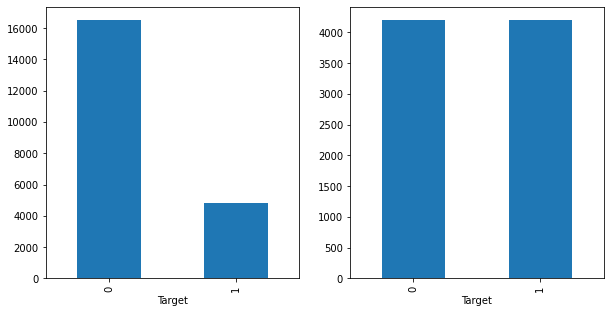

In [ ]:
import matplotlib.pyplot as plt
TRAIN_SAMPLES = 8416
#Balancing training set
train_df = balance_df(unbalanced_train_df,TRAIN_SAMPLES)
print(train_df.shape[0], 'Final training size')

In [ ]:
len(np.unique(train_df["path"].to_numpy()))

8416

## Setup training data generator

In [ ]:
# def preprocess_input(img):
#   return img
train_gen = MyBaseDataGenerator(train_df)
valid_gen = MyBaseDataGenerator(valid_df)

print(len(train_gen), "# of iterations in one train epoch")
print(len(valid_gen), "# of iterations in one validate epoch")

8416 :No of generator Image
2668 :No of generator Image
526 # of iterations in one train epoch
166 # of iterations in one validate epoch


In [ ]:
Set = 2
imageSet = train_gen[Set][0]
maskSet = train_gen[Set][1]   

In [ ]:
imageSet.shape,maskSet.shape

((16, 256, 256, 1), (16, 256, 256, 1))

In [ ]:
SetIndex = 0
imageIndex = Set*BATCH_SIZE + SetIndex
path = train_gen.filenames[imageIndex]
img = train_gen.getImage(path)

Text(0.5, 1.0, 'Mask')

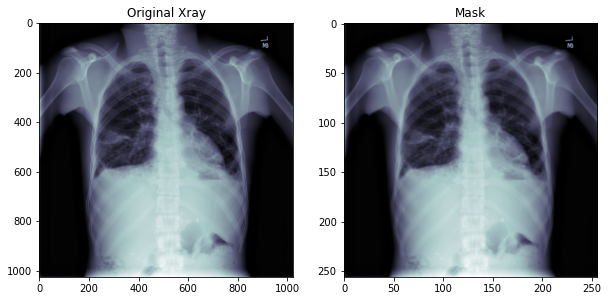

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, cmap=plt.cm.bone)
ax[0].set_title("Original Xray")
ax[1].imshow(imageSet[SetIndex][:,:,0],cmap=plt.cm.bone)
ax[1].set_title("Mask")
# The images are converted from RGB to BGR, 
#then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

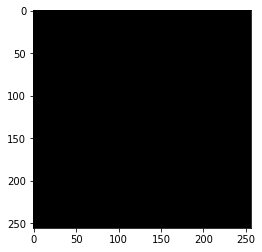

In [ ]:
show1CMaskedImage(imageSet,maskSet,0)

## Build model

In [ ]:
def add_downsample_layer(channels, inputs):
    x = BatchNormalization(momentum=0.9)(inputs)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = MaxPool2D(2)(x)
    return x

def add_resblock_layer(channels, inputs):
    x = BatchNormalization(momentum=0.9)(inputs)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return add([x, inputs])

def create_res_model(input_size, channels, n_blocks=2, depth=4):
    
    inputs = tf.keras.Input(shape=(input_size, input_size, 1))
    x = Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # Add res block
    for d in range(depth):
        channels = channels * 2
        x = add_downsample_layer(channels, x)
        for b in range(n_blocks):
            x = add_resblock_layer(channels, x)
  
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0)(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    outputs = UpSampling2D(2**depth)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from tensorflow.keras.layers import LeakyReLU,MaxPool2D,add
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)
def iou_loss(y_true, y_pred):
    #print(y_true)
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
   
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
    
model = create_res_model(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

def cosine_annealing(x):
    lr = 0.0001
    epochs = 3
    return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# print(model.summary())
# plot_model(model)

##Model Fit

In [ ]:

history = pd.DataFrame()

if (os.path.isfile(WEIGHTS_FILE) & (FORCE_TRAINING == False) ):
  model.load_weights(WEIGHTS_FILE)
  history = loadHistory(HISTORY_FILE)
else:
  if (os.path.isfile(WEIGHTS_FILE)):
    model.load_weights(WEIGHTS_FILE)
  history = model.fit(train_gen,   # (X_train, y_train)
                        epochs=EPOCHS,
                        validation_data=valid_gen,#(X_valid, y_valid)
                        callbacks=[learning_rate],
                        verbose=1,
                        workers=6)
  model.save(WEIGHTS_FILE)
  history = saveHistory(history,HISTORY_FILE)

Epoch 1/3
526/526 [==============================] - 1091s 2s/step - loss: 0.4600 - accuracy: 0.9364 - mean_iou: 0.4384 - val_loss: 0.4450 - val_accuracy: 0.9640 - val_mean_iou: 0.6311
Epoch 2/3
526/526 [==============================] - 823s 2s/step - loss: 0.4148 - accuracy: 0.9453 - mean_iou: 0.5139 - val_loss: 0.4283 - val_accuracy: 0.9653 - val_mean_iou: 0.6551
Epoch 3/3
526/526 [==============================] - 838s 2s/step - loss: 0.3896 - accuracy: 0.9495 - mean_iou: 0.5486 - val_loss: 0.4163 - val_accuracy: 0.9659 - val_mean_iou: 0.6249


## History

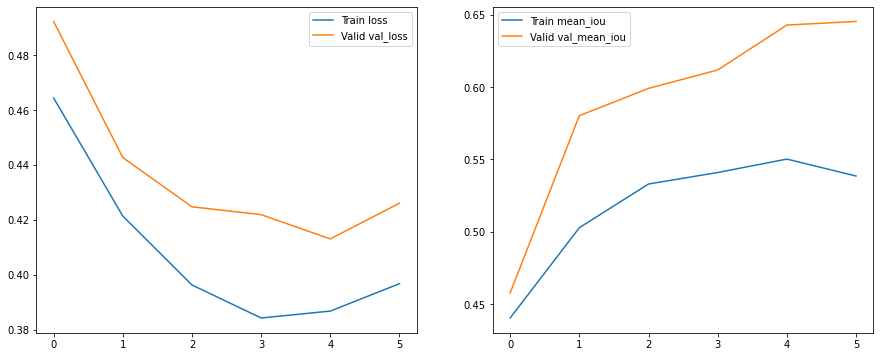

In [ ]:
plot_his(history)

## Predict sample image

In [ ]:
imageSet = valid_gen[9][0]
maskSet = valid_gen[9][1]
predMaskSet = model.predict(imageSet)


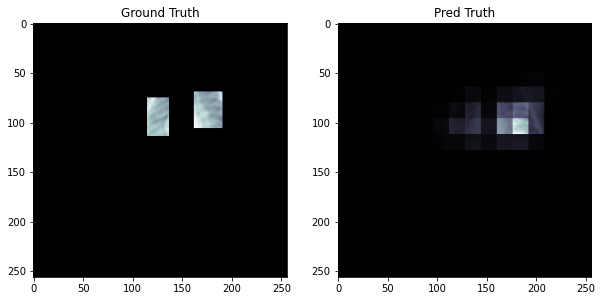

In [ ]:
loc = 3
show1CMaskedImage(imageSet,maskSet,loc,predMaskSet)

**Red** Bounding box: **PREDICTED**
**Blue** bouding box: **TRUTH**


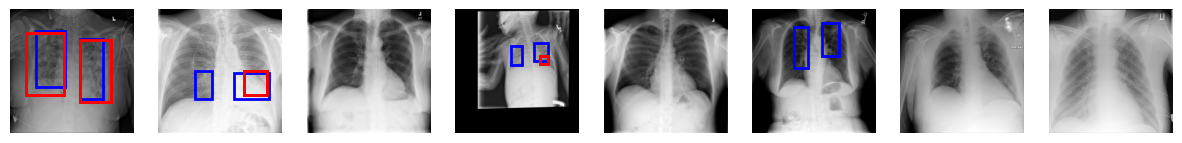

In [ ]:
#Show prediction on sample batch
showPredMaskedBatch(imageSet,maskSet,predMaskSet)

## Predict on test data set

In [ ]:
iou = 0.3
no_test = test_df.shape[0]
pred_file = MODEL_NAME + '/prediction.' +str(iou)+ str(no_test) +'.csv'
FORCE_PREDICTION = False;
pred_test_df = pd.DataFrame()
pred_test_df = 0
test_y = 0;
pred_y = 0
if ((os.path.isfile(pred_file) == False) | (FORCE_PREDICTION)):
  print('Predicting on test dataframe')
  #Pass test dataframe, bouding box map, trained mode, file to dump prediction, IoU threshold
  pred_test_df,test_y,pred_y = doMaskPrediction(test_df,bbox_map,model,pred_file,iou,True)
else:
  pred_test_df = pd.read_csv(pred_file)
  test_y = pred_test_df["Target"]
  pred_y = pred_test_df["predTarget"]
 
 

In [ ]:
len(set(pred_test_df[pred_test_df.predTarget == 1].patientId))

393

In [ ]:
len(set(pred_test_df[pred_test_df.Target == 1].patientId))

599

##Show top IOU prediction

In [ ]:
def mapna(row):
  # print(row)
  if (row == 'NA'):
    return 0
  return row
pred_test_df.iou = pred_test_df.iou.apply(mapna)


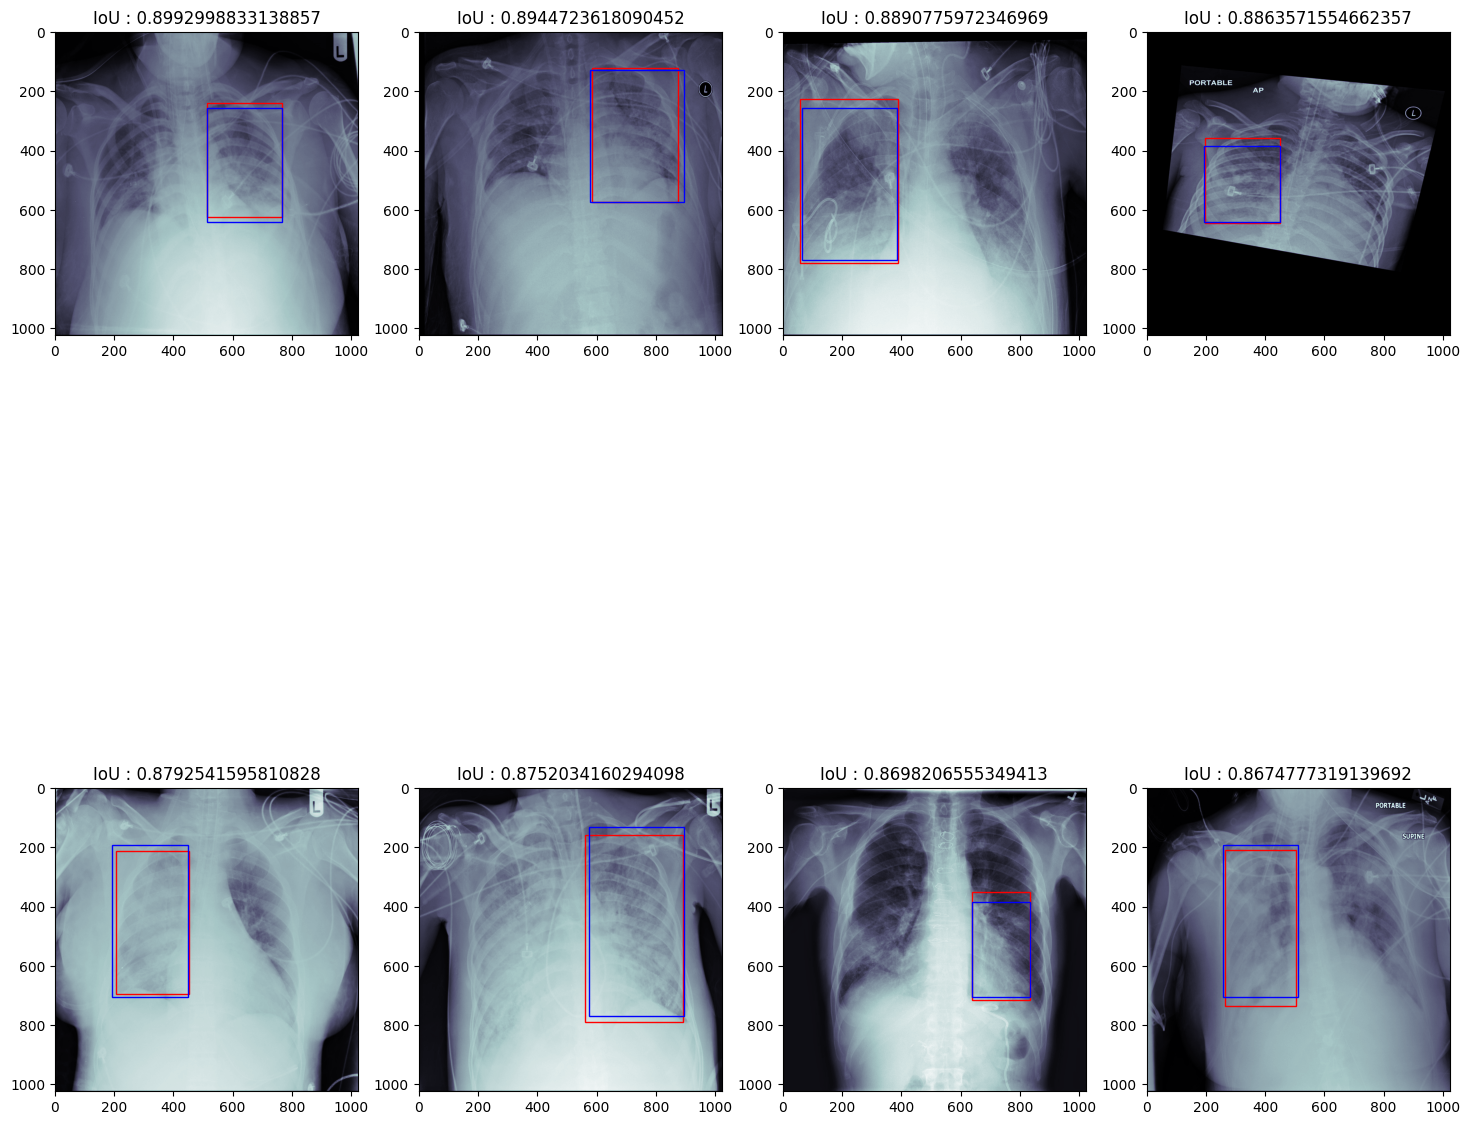

In [ ]:
# pred_test_df = pd.read_csv(pred_file)
def preprocess_input(img):
  return img
topNo = 8
show_top_prediction(pred_test_df,topNo)

## Performance(Recall)

In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(test_y, pred_y), "\n")
print("Classification Report:- \n", metrics.classification_report(test_y, pred_y))

Confusion Matrix:- 
 [[2057    0]
 [ 578  394]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      2057
           1       1.00      0.41      0.58       972

    accuracy                           0.81      3029
   macro avg       0.89      0.70      0.73      3029
weighted avg       0.85      0.81      0.78      3029



### Confidence score

## Conclusion